# Inductive Pagerank [DEMO]

The Inductive Pagerank technique is based on the APATE technique by Van Vlasselaer et al. (2016).
This technique is an important benchmark for network-based fraud detection. Hence, performance obtained in this notebook can be compared with performance of the CATCHM technique.

Before running the demo, please download the demo dataset from Kaggle:
https://www.kaggle.com/ranjeetshrivastav/fraud-detection-dataset


In [1]:
import os
import numpy as np
import pandas as pd
import networkx as nx
import xgboost as xgb
from fucc.metrics import plot_ap, get_optimal_f1_cutoff, get_confusion_matrix
from sklearn.metrics import average_precision_score
import logging
logging.basicConfig(level=logging.INFO)

In [2]:
from fucc.pagerank import get_pagerank_suspicion_scores, inductive_step, splitDataFrameIntoSmaller, postprocessing_historical_edges
from fucc.utils import get_filename, export_suspicion_scores, import_suspicion_scores, multiprocessing
from tqdm import tqdm
from functools import partial
import datetime
import pickle

In [3]:
# Parameters
weighted = True
lambdas = {'ST': 0.03, 'MT': 0.004, 'LT': 0.0001}
chunksize = 5000
# the 'workers' parameter is used for multi-processing.
WORKERS = 12

In [4]:
output_path = ''

## Load Data

In [5]:
### PATH TO DEMO DATA ###
demo_data_path = './transactions/transactions.txt'

In [6]:
df = pd.read_json(demo_data_path,  lines=True, convert_dates=[4])

In [7]:
# Transform fourth column to datetime format
df.iloc[:, 4] = pd.to_datetime(df.iloc[:, 4])

In [8]:
# Sort dataframe by datetime
df = df.sort_values('transactionDateTime')
# Create a transaction ID
df.loc[:, 'TX_ID'] = range(df.shape[0])

In [9]:
# Rename columns to work with hard-coded feature names in our code
df = df.rename(columns={"merchantName":"TERM_MIDUID", "customerId":"CARD_PAN_ID", "isFraud": "TX_FRAUD", "transactionDateTime":"TX_DATETIME"})

In [10]:
# Split into train, validation and test set
df_train = df.iloc[:320000]
df_val = df.iloc[320000:400000]
df_test = df.iloc[400000:500000]

In [11]:
# The 'personalization_nodes' are confirmed fraud cases that pagerank will use to assign suspicion scores to each node in the transaction network.
personalization_nodes = list(df_train.index)

## Pagerank

Pagerank is ran three times with different parameter values. 
- Short term
- Mid term
- Long term

In [12]:
%%time

dict_suspicion_scores = {}
dict_G = {}

for t, lambd in lambdas.items():
    suspicion_scores, G = get_pagerank_suspicion_scores(
                              df_train,
                              t=t,
                              lambd=lambd,
                              alpha=0.85,
                              n_jobs=WORKERS,
                              personalization_nodes=personalization_nodes,
                              weighted=weighted)


    dict_suspicion_scores[t] = suspicion_scores
    dict_G[t] = G

INFO:root:Building network
INFO:root:Calculating edge weights for ST
INFO:root:Calculating some weights
INFO:root:ok, ST
INFO:root:Personalization
INFO:root:Building graph ST
INFO:root:Pagerank started


327266
5350


INFO:root:Pagerank finished
INFO:root:Building network
INFO:root:Calculating edge weights for MT
INFO:root:Calculating some weights
INFO:root:ok, MT
INFO:root:Personalization
INFO:root:Building graph MT
INFO:root:Pagerank started


327266
5350


INFO:root:Pagerank finished
INFO:root:Building network
INFO:root:Calculating edge weights for LT
INFO:root:Calculating some weights
INFO:root:ok, LT
INFO:root:Personalization
INFO:root:Building graph LT
INFO:root:Pagerank started


327266
5350


INFO:root:Pagerank finished


CPU times: user 3min 28s, sys: 10.9 s, total: 3min 39s
Wall time: 4min 11s


In [13]:
%%time
## Get suspicion scores for the validation part of the training data
data = df_val.set_index('TX_ID')
data = data.loc[:, ['CARD_PAN_ID', 'TERM_MIDUID']]

# We only need these columns from historical data
historical_data = df_train.set_index('TX_ID')
historical_data = historical_data.loc[:, ['CARD_PAN_ID', 'TERM_MIDUID']]

# Inductive val set processing

dict_results = {}
for t,lamb in lambdas.items():

    suspicion_scores, G = dict_suspicion_scores[t], dict_G[t]

    # split df in smaller chunks
    chunks = splitDataFrameIntoSmaller(data, chunkSize=2000)
    partial_inductive_step = partial(inductive_step, historical_edges=historical_data, suspicion_scores=suspicion_scores, G=G, t=t)

    result = multiprocessing(function=partial_inductive_step, chunks=chunks)
    #f#ilename = get_filename(filename_elements=[subset_name, t])
    
    dict_results[t] = result
    #result.to_csv(os.path.join(output_path, filename + '_output_val.csv'))

df_val_pagerank = df_val.copy()
for t, lamb in lambdas.items():
    #filename = get_filename(filename_elements=[subset_name, t])
    df_pagerank = dict_results[t]
    #df_pagerank = df_pagerank.set_index('TX_ID')
    df_pagerank = df_pagerank.filter(regex='SC_*')
    df_val_pagerank = df_val_pagerank.merge(df_pagerank, left_on='TX_ID', right_index=True) 

#filename = get_filename(filename_elements=[subset_name])
#df_val_pagerank.to_csv(os.path.join(output_path, subset_name + '_val_pagerank_inductive.csv'))

  0%|          | 0/41 [00:00<?, ?it/s]INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
  2%|▏         | 1/41 [01:39<1:06:28, 99.71s/it]INFO:root:post processing started
INFO:root:post processing started
 15%|█▍        | 6/41 [01:49<41:04, 70.41s/it]  INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
 39%|███▉      | 16/41 [03:49<08:44, 20.96s/it]INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
 41%|████▏     | 17/41 [04:20<09:35, 23.97s/it]INFO:root:post processing started
INFO:root:post processing started
 51%|█████     | 21/41 [

CPU times: user 3min 27s, sys: 3min 21s, total: 6min 48s
Wall time: 24min 50s


In [14]:
%%time
# We only need these columns from data
data = df_test.set_index('TX_ID')
data = data.loc[:, ['CARD_PAN_ID', 'TERM_MIDUID']]

# We only need these columns from historical data
historical_data = df_train.set_index('TX_ID')
historical_data = historical_data.loc[:, ['CARD_PAN_ID', 'TERM_MIDUID']]

# Inductive test set processing

dict_results = {}
for t,lamb in lambdas.items():

    suspicion_scores, G = dict_suspicion_scores[t], dict_G[t]


    # split df in smaller chunks
    chunks = splitDataFrameIntoSmaller(data, chunkSize=2000)
    partial_inductive_step = partial(inductive_step, historical_edges=historical_data, suspicion_scores=suspicion_scores, G=G, t=t)

    result = multiprocessing(function=partial_inductive_step, chunks=chunks)
    dict_results[t] = result


df_test_pagerank = df_test.copy()
for t, lamb in lambdas.items():
    
    df_pagerank =  dict_results[t] 
    df_pagerank = df_pagerank.filter(regex='SC_*')
    df_test_pagerank = df_test_pagerank.merge(df_pagerank, left_on='TX_ID', right_index=True)


  0%|          | 0/51 [00:00<?, ?it/s]INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
 12%|█▏        | 6/51 [03:11<38:47, 51.73s/it]  INFO:root:post processing started
INFO:root:post processing started
 16%|█▌        | 8/51 [03:35<28:28, 39.74s/it]INFO:root:post processing started
INFO:root:post processing started
 25%|██▌       | 13/51 [05:12<13:36, 21.50s/it]INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
 41%|████      | 21/51 [06:19<03:50,  7.68s/it]INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
 55%|█████▍    | 28/51 [07:16<02:25,  6.33s/it]INFO:root:post processing started
INFO:root:post processing started
 57%|█████▋  

 43%|████▎     | 22/51 [02:53<01:52,  3.87s/it]INFO:root:post processing started
INFO:root:post processing started
 47%|████▋     | 24/51 [02:59<01:26,  3.20s/it]INFO:root:post processing started
INFO:root:post processing started
 63%|██████▎   | 32/51 [03:53<00:51,  2.68s/it]INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
 78%|███████▊  | 40/51 [04:52<00:35,  3.26s/it]INFO:root:post processing started
INFO:root:post processing started
 82%|████████▏ | 42/51 [05:33<01:33, 10.44s/it]INFO:root:post processing started
INFO:root:post processing started
100%|██████████| 51/51 [06:13<00:00,  7.32s/it]


CPU times: user 3min 57s, sys: 2min 28s, total: 6min 26s
Wall time: 22min 47s


In [15]:
%%time
# We only need these columns from data
data = df_test.set_index('TX_ID')
data = data.loc[:, ['CARD_PAN_ID', 'TERM_MIDUID']]

# We only need these columns from historical data
historical_data = df_train.set_index('TX_ID')
historical_data = historical_data.loc[:, ['CARD_PAN_ID', 'TERM_MIDUID']]


# transductive train set processing
dict_results = {}
for t, lamb in lambdas.items():
    print(t)
    suspicion_scores, G = dict_suspicion_scores[t], dict_G[t]


    #Split historical dataset into smaller chunks
    chunks = splitDataFrameIntoSmaller(historical_data, chunkSize=5000)
    partial_postprocessing_historical_edges = partial(postprocessing_historical_edges, suspicion_scores=suspicion_scores, t=t)
    #partial_inductive_step = partial(inductive_step, historical_edges=historical_data, suspicion_scores=suspicion_scores, G=G, t=t)
    
    result = multiprocessing(function=partial_postprocessing_historical_edges, chunks=chunks)
    dict_results[t] = result

df_train_pagerank = df_train.copy()
# Load and join ST, MT, LT data for df_train and df_train
for t, lamb in lambdas.items():
    df_pagerank = dict_results[t]
    df_pagerank = df_pagerank.filter(regex='SC_*')
    df_train_pagerank = df_train_pagerank.merge(df_pagerank, left_on='TX_ID', right_index=True)

ST


100%|██████████| 65/65 [01:55<00:00,  1.77s/it]


MT


100%|██████████| 65/65 [02:10<00:00,  2.01s/it]


LT


100%|██████████| 65/65 [02:10<00:00,  2.00s/it]


CPU times: user 12.3 s, sys: 5.49 s, total: 17.8 s
Wall time: 6min 21s


## XGBoost Classifier

In [16]:
df_train = df_train_pagerank
df_val = df_val_pagerank
df_test = df_test_pagerank

In [17]:
pagerank_features = list(df_train.filter(regex='SC').columns)

In [18]:
X_train = df_train[pagerank_features]
X_val = df_val[pagerank_features]
y_train = df_train.TX_FRAUD
y_val = df_val.TX_FRAUD

X_test = df_test[pagerank_features]
y_test = df_test.TX_FRAUD

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

In [19]:
xgb_params = {
    'eval_metric': ['auc','aucpr', 'logloss'],
    'objective':'binary:logistic',
    'n_estimators': 300,
    'n_jobs':8,
    'learning_rate':0.1,
    'seed':42,
    'colsample_bytree':0.6,
    'colsample_bylevel':0.9,
    'subsample':0.9
}

In [20]:
model = xgb.train(xgb_params, dtrain, num_boost_round=xgb_params['n_estimators'], evals=[(dval, 'val'), (dtrain, 'train')], early_stopping_rounds=int(xgb_params['n_estimators']/2))

[13:02:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	val-auc:0.68548	val-aucpr:0.06875	val-logloss:0.60422	train-auc:0.75759	train-aucpr:0.18928	train-logloss:0.60348
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 150 rounds.
[1]	val-auc:0.70612	val-aucpr:0.10293	val-logloss:0.53334	train-auc:0.76711	train-aucpr:0.24243	train-logloss:0.53062
[2]	val-auc:0.71811	val-aucpr:0.11471	val-logloss:0.47251	train-auc:0.77107	train-aucpr:0.25921	train-logloss:0.46990
[3]	val-auc:0.70730	val-aucpr:0.11572	val-logloss:0.42155	train-auc:0.78992	train-aucpr:0.30336	train-l

[65]	val-auc:0.68161	val-aucpr:0.16886	val-logloss:0.09620	train-auc:0.85853	train-aucpr:0.40537	train-logloss:0.05857
[66]	val-auc:0.67861	val-aucpr:0.16818	val-logloss:0.09704	train-auc:0.85869	train-aucpr:0.40559	train-logloss:0.05850
[67]	val-auc:0.67918	val-aucpr:0.16803	val-logloss:0.09697	train-auc:0.85893	train-aucpr:0.40601	train-logloss:0.05844
[68]	val-auc:0.67898	val-aucpr:0.16988	val-logloss:0.09700	train-auc:0.86005	train-aucpr:0.40757	train-logloss:0.05832
[69]	val-auc:0.67865	val-aucpr:0.17044	val-logloss:0.09693	train-auc:0.86061	train-aucpr:0.40807	train-logloss:0.05824
[70]	val-auc:0.67898	val-aucpr:0.16994	val-logloss:0.09756	train-auc:0.86204	train-aucpr:0.40949	train-logloss:0.05812
[71]	val-auc:0.67980	val-aucpr:0.17035	val-logloss:0.09751	train-auc:0.86264	train-aucpr:0.41005	train-logloss:0.05801
[72]	val-auc:0.67855	val-aucpr:0.17043	val-logloss:0.09875	train-auc:0.86326	train-aucpr:0.41086	train-logloss:0.05788
[73]	val-auc:0.67751	val-aucpr:0.17051	val-loglo

[134]	val-auc:0.66711	val-aucpr:0.18104	val-logloss:0.12720	train-auc:0.89056	train-aucpr:0.44759	train-logloss:0.05414
[135]	val-auc:0.66751	val-aucpr:0.18082	val-logloss:0.12718	train-auc:0.89099	train-aucpr:0.44786	train-logloss:0.05411
[136]	val-auc:0.66735	val-aucpr:0.18087	val-logloss:0.12809	train-auc:0.89106	train-aucpr:0.44803	train-logloss:0.05409
[137]	val-auc:0.66742	val-aucpr:0.18089	val-logloss:0.12809	train-auc:0.89133	train-aucpr:0.44839	train-logloss:0.05406
[138]	val-auc:0.66725	val-aucpr:0.18090	val-logloss:0.12809	train-auc:0.89184	train-aucpr:0.44892	train-logloss:0.05402
[139]	val-auc:0.66730	val-aucpr:0.18093	val-logloss:0.12806	train-auc:0.89189	train-aucpr:0.44903	train-logloss:0.05402
[140]	val-auc:0.66687	val-aucpr:0.18016	val-logloss:0.12823	train-auc:0.89219	train-aucpr:0.44928	train-logloss:0.05399
[141]	val-auc:0.66672	val-aucpr:0.18049	val-logloss:0.12822	train-auc:0.89264	train-aucpr:0.45078	train-logloss:0.05393
[142]	val-auc:0.66672	val-aucpr:0.18036	

[203]	val-auc:0.67129	val-aucpr:0.18424	val-logloss:0.13757	train-auc:0.91229	train-aucpr:0.48288	train-logloss:0.05155
[204]	val-auc:0.67100	val-aucpr:0.18430	val-logloss:0.13774	train-auc:0.91253	train-aucpr:0.48342	train-logloss:0.05152
[205]	val-auc:0.67096	val-aucpr:0.18430	val-logloss:0.13775	train-auc:0.91260	train-aucpr:0.48350	train-logloss:0.05151
[206]	val-auc:0.67127	val-aucpr:0.18402	val-logloss:0.13815	train-auc:0.91260	train-aucpr:0.48353	train-logloss:0.05151
[207]	val-auc:0.67094	val-aucpr:0.18398	val-logloss:0.13820	train-auc:0.91289	train-aucpr:0.48417	train-logloss:0.05147
[208]	val-auc:0.67099	val-aucpr:0.18408	val-logloss:0.13820	train-auc:0.91312	train-aucpr:0.48483	train-logloss:0.05143
[209]	val-auc:0.67040	val-aucpr:0.18409	val-logloss:0.13814	train-auc:0.91324	train-aucpr:0.48522	train-logloss:0.05141
[210]	val-auc:0.67093	val-aucpr:0.18371	val-logloss:0.13805	train-auc:0.91328	train-aucpr:0.48547	train-logloss:0.05139
[211]	val-auc:0.67107	val-aucpr:0.18307	

[272]	val-auc:0.67119	val-aucpr:0.18477	val-logloss:0.14156	train-auc:0.92623	train-aucpr:0.51430	train-logloss:0.04943
[273]	val-auc:0.67143	val-aucpr:0.18523	val-logloss:0.14154	train-auc:0.92637	train-aucpr:0.51499	train-logloss:0.04939
[274]	val-auc:0.67166	val-aucpr:0.18572	val-logloss:0.14151	train-auc:0.92659	train-aucpr:0.51525	train-logloss:0.04936
[275]	val-auc:0.67166	val-aucpr:0.18559	val-logloss:0.14153	train-auc:0.92673	train-aucpr:0.51606	train-logloss:0.04931
[276]	val-auc:0.67166	val-aucpr:0.18559	val-logloss:0.14154	train-auc:0.92674	train-aucpr:0.51612	train-logloss:0.04931
[277]	val-auc:0.67171	val-aucpr:0.18563	val-logloss:0.14152	train-auc:0.92683	train-aucpr:0.51651	train-logloss:0.04929
[278]	val-auc:0.67099	val-aucpr:0.18564	val-logloss:0.14182	train-auc:0.92707	train-aucpr:0.51682	train-logloss:0.04927
[279]	val-auc:0.67070	val-aucpr:0.18563	val-logloss:0.14175	train-auc:0.92734	train-aucpr:0.51748	train-logloss:0.04923
[280]	val-auc:0.67073	val-aucpr:0.18572	

In [21]:
y_pred_proba = model.predict(dtest)

## Evaluation

In [22]:
ap = average_precision_score(y_test, y_pred_proba)
print("Average Precision: ", np.round(ap,2))

Average Precision:  0.19


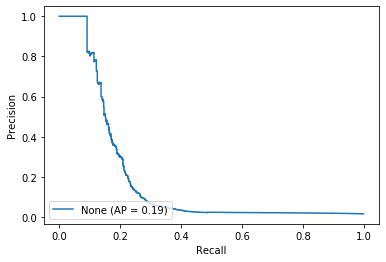

In [23]:
fig = plot_ap(y_test, y_pred_proba)

In [24]:
optimal_threshold, optimal_f1_score = get_optimal_f1_cutoff(y_test, y_pred_proba)
print("F1 Score: ", np.round(optimal_f1_score, 4))

F1 Score:  0.243


In [25]:
cm = get_confusion_matrix(y_test, y_pred_proba, optimal_threshold)
print("Confusion Matrix: \n", cm)

Confusion Matrix: 
 [[97932   523]
 [ 1259   286]]


In [26]:
from sklearn.metrics import roc_auc_score

In [27]:
roc_auc_score(y_test, y_pred_proba)

0.6695896158759632